In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.nn as nn

### Creating the model

In [50]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [51]:
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-09 01:57:20--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  34.5MB/s    in 9.8s    

2021-03-09 01:57:30 (34.4 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [52]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


### Downloading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
try:
  !rm oxbuild_images.tgz
except:
  print("Does not exist")

In [9]:
!rm -rf oxbuild_images/

In [10]:
ls

 177941373.pdf                  model.pt
'Brueghel.zip?dl=0'             Photo_ImadEddine.JPG
 colab/                         shape1.JPG
'Colab Notebooks'/              shape_priors/
 cs_398/                        train_sp_cnn.ipynb
 Dataset_IR_RGB/                Transcript_ImadEddineMAROUF.pdf
 English_ImadEddineMAROUF.pdf   Transcript.pdf
'Health Certificate.pdf'        Verification_ImadEddineMAROUF.pdf
'ImadEddine_MAROUF .pdf'


In [11]:
mkdir oxbuild_images 

In [12]:
cd oxbuild_images

/content/gdrive/MyDrive/oxbuild_images


In [13]:
!wget https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz

--2021-03-09 01:41:31--  https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1980280437 (1.8G) [application/x-gzip]
Saving to: ‘oxbuild_images.tgz’

oxbuild_images.tgz  100%[===================>]   1.84G  21.5MB/s    in 91s     

2021-03-09 01:43:02 (20.8 MB/s) - ‘oxbuild_images.tgz’ saved [1980280437/1980280437]



In [14]:
ls

oxbuild_images.tgz


In [ ]:
!tar -zxvf oxbuild_images.tgz

In [ ]:
ls

In [17]:
import os
from os import listdir
from os.path import isfile, join
import shutil

data_dir = '/content/gdrive/MyDrive/'

# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

for f in listdir(join(data_dir, 'oxbuild_images')):
    # create directory if necessary
    label = f[:-11]
    path = join(data_dir, 'oxbuild_images', label)
    check_dir(path)
    # copy to target directory
    src_path = join(data_dir, 'oxbuild_images', f)
    targ_path = join(path, f)
    shutil.copy(src_path, targ_path)

In [19]:
rm *.jpg

In [20]:
ls

all_souls/  christ_church/  keble/     oxbuild/            radcliffe_camera/
ashmolean/  cornmarket/     magdalen/  oxbuild_images.tgz  trinity/
balliol/    hertford/       new/       oxford/             worcester/
bodleian/   jesus/          oriel/     pitt_rivers/


In [21]:
rm oxbuild_images.tgz

In [22]:
cd ..

/content/gdrive/My Drive


In [ ]:
!mv  oxbuild_images train
!mkdir oxbuild_images
!mv train oxbuild_images

In [29]:
cd oxbuild_images

/content/gdrive/My Drive/oxbuild_images


In [30]:
ls

train/


### Loading dataset

In [38]:
data_dir = '/content/gdrive/My Drive/oxbuild_images/train'
dsets = datasets.ImageFolder(data_dir, preprocess)

In [39]:
dsets

Dataset ImageFolder
    Number of datapoints: 5063
    Root location: /content/gdrive/My Drive/oxbuild_images/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [40]:
print(dsets.classes, sep='\n')

['all_souls', 'ashmolean', 'balliol', 'bodleian', 'christ_church', 'cornmarket', 'hertford', 'jesus', 'keble', 'magdalen', 'new', 'oriel', 'oxbuild', 'oxford', 'pitt_rivers', 'radcliffe_camera', 'trinity', 'worcester']


In [41]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=2)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
device

'cuda'

In [44]:
images, labels = next(iter(data_loader))
print("Images shape: ", images.shape)

Images shape:  torch.Size([16, 3, 224, 224])


In [45]:
img = images[0].unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


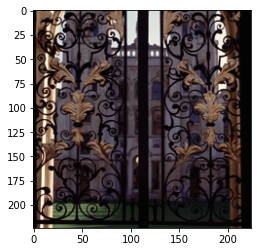

In [46]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

### Regional Max-Pooling

In [47]:
import math
import torch.nn.functional as F

def rmac(x, L=5, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v

In [53]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

class MyModel2(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=(3, 3), bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)             #[1, 768, 257, 257]
    #Regional Max-Pooling
    output = out / (torch.norm(out, p=2, dim=1, keepdim=True) + 1e-12).expand_as(out)
    #output = torch.nn.functional.normalize(out, p=2.0, dim=1)
    output = rmac(output)
    return output

In [54]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [55]:
conv = MyModel2(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)

print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel2(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(3, 3), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [56]:
def get_features(dataset):
    all_features = []
    all_labels = []
    imgs = []
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset)):
            features = conv(images.to(device))
            imgs.append(images)
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy(), imgs

In [59]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

conv = conv.eval().to(device)

# Calculate the image features
features, labels, imgs = get_features(dsets)

In [68]:
features_np = np.zeros((len(features), features[0].shape[0]))
for i, value in enumerate(features):
  value = value.squeeze(1).squeeze(1)
  features_np[i] = value

In [69]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=22)
pca.fit(features_np)
target= pca.transform(features_np)
print("After PCA: ", target.shape)

After PCA:  (5063, 100)


In [70]:
# clustering and dimension reduction
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=17,n_jobs=-1, random_state=22)
kmeans.fit(target)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [71]:
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

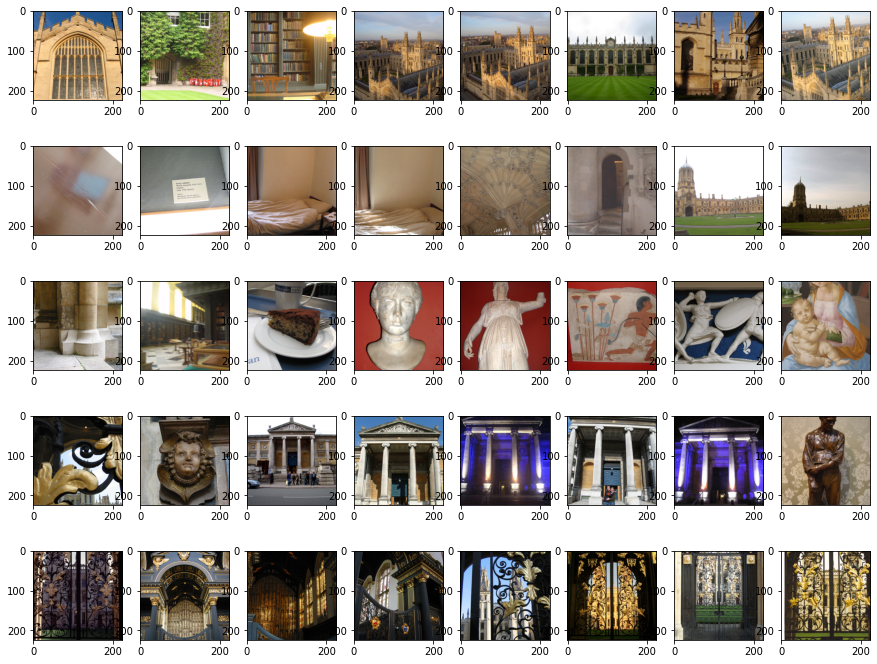

In [72]:
import matplotlib.pyplot as plt

#Cluster 0
fig, ax = plt.subplots(5, 8, figsize=(15, 12))
clusters = [0, 1, 2, 4, 5]
for i in range(5):
  for j in range(8):
    img_id = groups[clusters[i]][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))

### Using all Visual network for ViT model

In [74]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-09 02:13:08--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  61.2MB/s    in 5.7s    

2021-03-09 02:13:14 (58.9 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [75]:
import numpy as np
import torch
from tqdm.notebook import tqdm

In [76]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

In [77]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

In [78]:
def get_features(dataset):
    all_features = []
    all_labels = []
    imgs = []
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset)):
            features = model.encode_image(images.to(device))
            imgs.append(images)
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy(), imgs

In [79]:
from torch.utils.data import DataLoader

model = torch.jit.load("model.pt").cuda().eval()
# Calculate the image features
features, labels, imgs = get_features(dsets)

In [80]:
features[0].shape

(512,)

In [81]:
features_np = np.zeros((len(features), features[0].shape[0]))
for i, value in enumerate(features):
  features_np[i] = value

In [82]:
features_np.shape

(5063, 512)

In [83]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=22)
pca.fit(features_np)
target= pca.transform(features_np)
print("After PCA: ", target.shape)

After PCA:  (5063, 100)


### K-Means Clustering

In [84]:
# clustering and dimension reduction
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=17,n_jobs=-1, random_state=22)
kmeans.fit(target)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [85]:
kmeans.labels_[:25]

array([10,  9,  9, 11, 16,  9,  9,  9,  9, 10, 11,  9,  9,  9, 10, 10, 10,
       10, 10,  9, 10, 10,  9,  1,  9], dtype=int32)

In [86]:
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

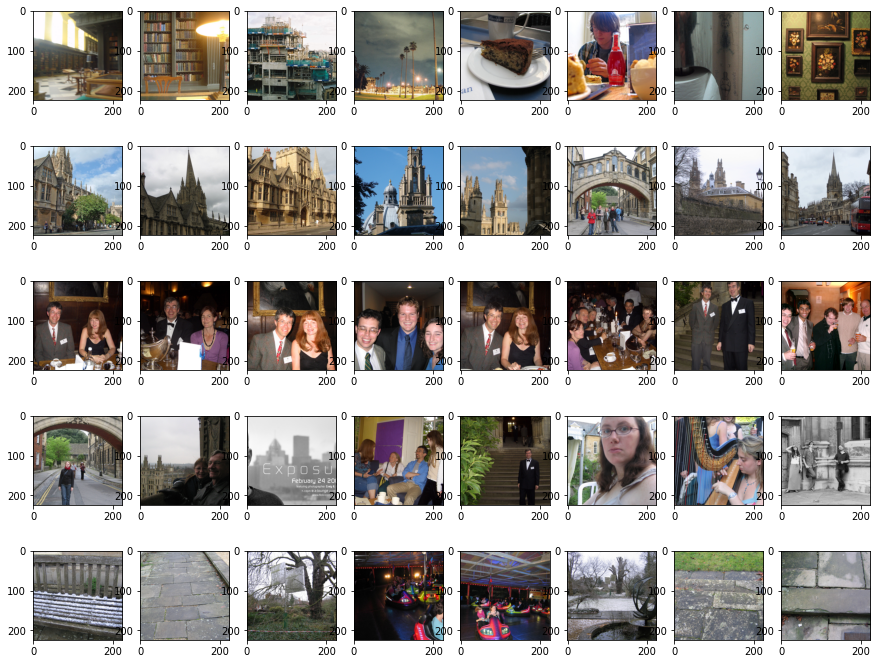

In [87]:
#Cluster 0
fig, ax = plt.subplots(5, 8, figsize=(15, 12))
clusters = [0, 1, 2, 4, 5]
for i in range(5):
  for j in range(8):
    img_id = groups[clusters[i]][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))